# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">7. Integration and Final Predictions</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |

---

### **8. Integration and Final Predictions Notebook**  
**Description:**  
This notebook integrates and compares the results of both **hierarchical classification** and **flat classification** approaches to produce the final outputs and evaluate the entire pipeline.  

Key steps include:  
- **Loading Predictions:** Import predictions from **Flat Modeling** (Notebook 7) and **Hierarchical Modeling** (Levels 1, 2 Binary, and 2 Multi-Class).  
- **Combining Predictions:** Merge outputs from both approaches to enable a side-by-side comparison.  
- **Performance Evaluation:** Compare flat and hierarchical models using metrics such as accuracy, F1-score, precision, recall, and confusion matrices.  
- **Analysis:** Discuss the advantages, disadvantages, and trade-offs of each approach. Highlight scenarios where one approach outperforms the other.  
- **Output:** Save the final predictions from both approaches for deployment, further reporting, or stakeholder presentation.  

This notebook serves as the final step in the pipeline, providing a detailed evaluation of the two modeling strategies and ensuring clarity on their relative performance and practical implications.  

---


## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Load and Prepare Datasets](#chapter2)
* [3. Combining Predictions](#chapter3)
* [4. Performance Evaluation](#chapter4)
* [5. Analysis](#chapter5)
* [6. Output](#chapter6)

# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>
[Back to ToC](#toc)<br>

In [2]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 


# --- Feature Selection Methods ---
# Filter Methods
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest

# Wrapper Methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV

# --- Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#from xgboost import XGBClassifier

# --- Warnings ---


import warnings
warnings.filterwarnings('ignore')

from utils import plot_importance, cor_heatmap, find_optimal_features_with_rfe, compare_rf_feature_importances,compare_feature_importances, select_high_score_features_chi2_no_model,select_high_score_features_MIC, metrics

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>
[Back to ToC](#toc)<br>

For our final evaluation, we are going to import the final datasets results from the previous notebooks.

In [10]:
# Load the first dataset
#X_test_final_1 = pd.read_csv('X_test_final_1.csv')
# Load the second dataset
#X_test_final_2 = pd.read_csv('X_test_final_2.csv')

# 3.Combining Predictions <a class="anchor" id="chapter3"></a>
[Back to ToC](#toc)<br>

In [6]:
X_test_final_combined = pd.read_csv("../processed_datasets/df_test_predictions_not5.csv", index_col="Claim Identifier")

In [14]:
X_test_final_combined.head()

,Claim Identifier,Age at Injury,IME-4 Count,Income_Category,Accident_Quarter,Accident_Year,Accident Day,Age Group,promptness_category,promptness_C2_category,...,County of Injury_freq,District Name_freq,WCIO Cause of Injury Code_freq,WCIO Nature of Injury Code_freq,WCIO Part Of Body Code_freq,Carrier Name_freq,Body_Part_Category_freq,Injury_Nature_Category_freq,Carrier Type Merged_freq,Pred_notebook_5
0,6165911,19,0.0,3,4,2022,5,3,3,3,...,31684,216798,25490,88312,9326,7246.0,96343,404174,228492,2. NON-COMP
1,6166141,19,0.0,1,4,2022,6,3,0,0,...,46587,216798,14632,88312,6322,8907.0,45491,404174,228492,4. TEMPORARY
2,6165907,59,0.0,2,4,2022,0,0,7,7,...,20637,216798,8659,44601,929,149.0,80866,404174,228492,4. TEMPORARY
3,6166047,42,0.0,3,4,2022,2,2,7,7,...,46587,216798,9604,88312,38469,11544.0,96343,404174,228492,2. NON-COMP
4,6166102,25,0.0,3,4,2022,1,3,3,3,...,42680,216798,9935,37603,9984,10237.0,142559,404174,228492,4. TEMPORARY


In [9]:
# Check our final results
X_test_final_combined['Pred_notebook_5'].value_counts()

Pred_notebook_5
4. TEMPORARY    262683
2. NON-COMP     125292
Name: count, dtype: int64

# 4. Performance Evaluation <a class="anchor" id="chapter4"></a>
[Back to ToC](#toc)<br>

In [26]:
# Map the 'Final_Predictions' values to injury types
injury_type_mapping = {
    1: "1. CANCELLED",
    2: "2. NON-COMP",
    3: "3. MED ONLY",
    4: "4. TEMPORARY",
    5: "5. PPD SCH LOSS",
    6: "6. PPD NSL",
    7: "7. PTD",
    8: "8. DEATH"
}

# Ensure 'Pred_notebook_5' contains valid integers
X_test_final_combined['Pred_notebook_5'] = pd.to_numeric(X_test_final_combined['Pred_notebook_5'], errors='coerce')

# Handle any NaN or invalid values that might have been coerced
X_test_final_combined = X_test_final_combined.dropna(subset=['Pred_notebook_5'])

# Map the injury types and format the 'Claim Injury Type' column
X_test_final_combined['Claim Injury Type'] = (
    X_test_final_combined['Pred_notebook_5'].astype(int).astype(str) + ". " + 
    X_test_final_combined['Pred_notebook_5'].map(injury_type_mapping)
)

# Select only the necessary columns for submission
submission = X_test_final_combined[['Claim Identifier', 'Claim Injury Type']]

# Display the first rows of the generated file
print(submission.head())


Empty DataFrame
Columns: [Claim Identifier, Claim Injury Type]
Index: []


In [19]:
# Save the submission file and capture its path
submission.to_csv('submission.csv', index=False)
import os
print(os.getcwd())

c:\Users\joaom\Desktop\NOVA IMS\1ºano\1ºsemestre\Machine Learning\Nova pasta\Machine_Learning_project\Deliverables


--> este código tem que ser adptado

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Check the first few rows of the dataset
print(X_test_final_combined.head())

# Define the columns
true_labels = X_test_final_combined['True Labels']  # Replace with the correct name for the ground truth labels column
flat_predictions = X_test_final_combined['Flat Model Predictions']  # Replace with the correct name for flat model predictions
hierarchical_predictions = X_test_final_combined['Hierarchical Model Predictions']  # Replace with the correct name for hierarchical model predictions

# Use the metrics function to compare the two models
print("Flat Model Metrics:")
metrics(true_labels, flat_predictions, true_labels, flat_predictions)

print("\nHierarchical Model Metrics:")
metrics(true_labels, hierarchical_predictions, true_labels, hierarchical_predictions)


Empty DataFrame
Columns: [Claim Identifier, Age at Injury, IME-4 Count, Income_Category, Accident_Quarter, Accident_Year, Accident Day, Age Group, promptness_category, promptness_C2_category, promptness_C3_category, Industry Risk, Salary_Per_Dependent, Gender_M, Gender_U, Medical Fee Region_II, Medical Fee Region_III, Medical Fee Region_UK, Carrier_Name_Simplified_freq, Zip_Code_Simplified_freq, Industry Code_freq, County of Injury_freq, District Name_freq, WCIO Cause of Injury Code_freq, WCIO Nature of Injury Code_freq, WCIO Part Of Body Code_freq, Carrier Name_freq, Body_Part_Category_freq, Injury_Nature_Category_freq, Carrier Type Merged_freq, Pred_notebook_5, Claim Injury Type]
Index: []

[0 rows x 32 columns]


KeyError: 'True Labels'

# 5. Analysis <a class="anchor" id="chapter5"></a>
[Back to ToC](#toc)<br>

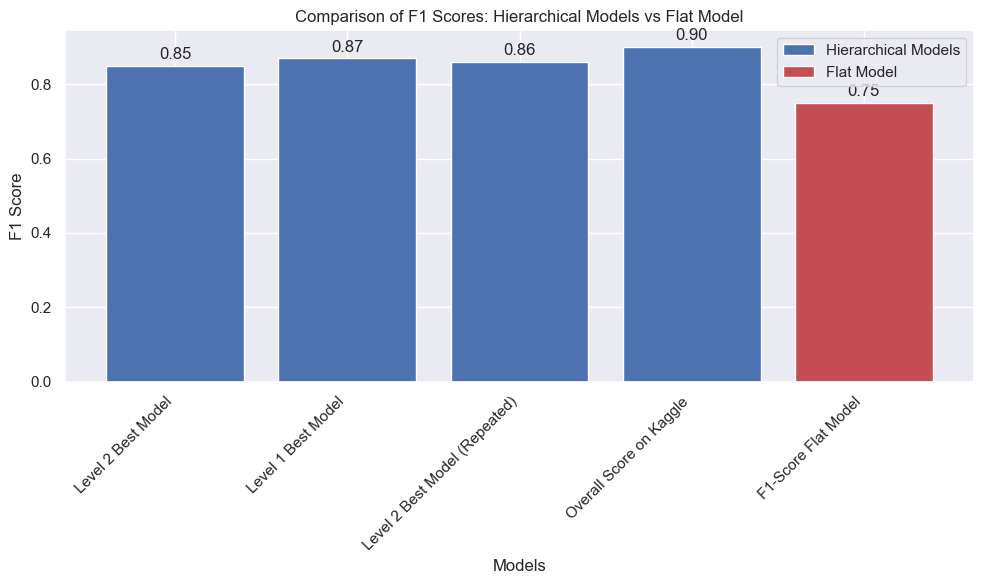

In [21]:
labels = ["Level 2 Best Model", "Level 1 Best Model", "Level 2 Best Model (Repeated)", "Overall Score on Kaggle", "F1-Score Flat Model"]
f1_scores = [0.85, 0.87, 0.86, 0.90, 0.75]  # F1-scores for the models
f1_scores_flat_model = [0.75]  # F1-Score for the flat model for comparison

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels[:-1], f1_scores[:-1], color='b', label='Hierarchical Models')
flat_bar = plt.bar(labels[-1], f1_scores_flat_model, color='r', label='Flat Model')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores: Hierarchical Models vs Flat Model')
plt.legend()

# Add percentages (values) above the bars
for bar in bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')  # Position text above the bar

# For the flat model
for bar in flat_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout to prevent text overlap
plt.show()



### Conclusions:

# 6. Output <a class="anchor" id="chapter6"></a>
[Back to ToC](#toc)<br>